# LSI and Scikit-Learn
    Daniel Perkins
    MATH 403
    9/26/24

In [1]:
import os
import string
import numpy as np
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
import sklearn
print(sklearn.__version__)

1.2.2


## Problem 1
- Perform PCA on the breast cancer dataset
- Graph the first two principal components
- Calculate the variance captured by the first two principal components

In [5]:
def prob1():
    """Recreate the plot in Figure 1 by performing PCA on the breast 
    cancer dataset. Translate the columns of X to have mean 0.
    Include the amount of variance captured by the first two principal 
    components in the graph title."""
    
    # Load in data
    cancer = datasets.load_breast_cancer()
    X = cancer.data
    y = cancer.target # Class labels (0 or 1)
    
    # print(X)
    Y = X - np.mean(X, axis=0)  # Center columns on mean
    U, S, Vh = la.svd(Y)  # Compute the SVD (S is vector of singular values)
    Y_hat = U[:,:2] * S[:2]  # Project samples ontu 2D space
    
    # Extract meaningful data
    pca1, pca2 = Y_hat[:,0], Y_hat[:,1] # 2-D PCA
    proportion = (S[0]**2 + S[1]**2) / np.sum(S**2)  # Equation (7.1)
    
    # Masks
    ben_mask = np.where(y == 1)[0]
    mal_mask = np.where(y == 0)[0]
    
    # Plot it
    plt.title(f"Breast Cancer PCA with {100*round(proportion, 4)}% of the variance")
    plt.ylabel("Second Principal Component")
    plt.xlabel("First Principal Component")
    plt.scatter(pca1[mal_mask], pca2[mal_mask], marker=".", linewidths=.3, alpha=.4, label="Malignant", color="red")
    plt.scatter(pca1[ben_mask], pca2[ben_mask], marker=".", linewidths=.3, alpha=.4, label="Benign", color="green")
    plt.legend()
    plt.show()
    print(f"{100*proportion}% of the variance was captured.")

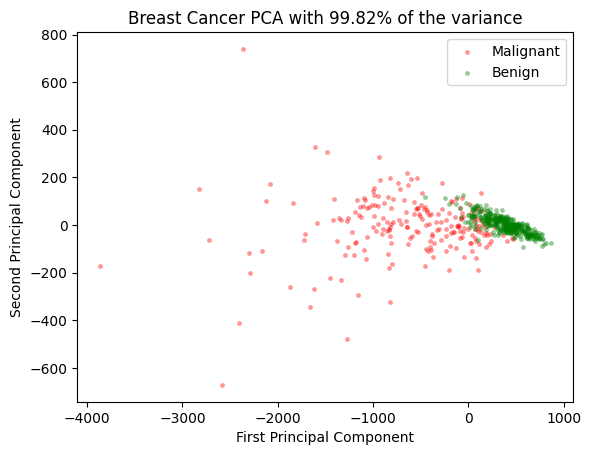

99.82211613741725% of the variance was captured.


In [6]:
prob1()

## Problem 2
Implement the function similar()

In [8]:
def similar(i, Xhat):
    """
    Takes an index and matrix representing the principal components 
    of a document and returns two indices: the index of the document 
    that is least similar and the index of the document that is most 
    similar to i.
    
    Parameters:
        i: index of a document
        Xhat: decomposed data
    
    Returns:
        index_max: index of the document most similar to document i
        index_min: index of the document least similar to document i
    """
    similarities = []
    for j in range(len(Xhat)):
        if j == i:  # Don't want it to match itself
            similarities.append(-np.inf)  
            continue
        # Calculate cosine similarity
        num = Xhat[i] @ Xhat[j]
        den = la.norm(Xhat[i]) * la.norm(Xhat[j])
        similarities.append(num / den)
    # Sort by index to find max and min
    sorted_similarities = np.argsort(similarities)
    # print(sorted_similarities)
    index_min = sorted_similarities[1]  # Second to last (to ignore repeated document)
    index_max = sorted_similarities[-1]  
    return index_max, index_min
        

In [8]:
# Test case
X = np.array([
    [0.78, 0.14, 0.12, 0.],
    [0.64, 0.97, 0., 0.],
    [0., 0., 0.63, 0.46],
    [0., 0.84, 0.6, 0.],
    [0.29, 0.89, 0.51, 0.],
    [0.77, 0., 0.27, 0.2],
    [0.86, 0.47, 0., 0.06],
    [0.89, 0., 0., 0.]
]) 
print(similar(4, X))

(3, 7)


### Function for Problem 3

In [5]:
def document_converter():
    """
    Converts speech documents into an m by n array where n is the number 
    of vocabulary words and m is the number of documents.
    
    Returns:
        X ((m x n) sparse matrix): Each row represents a document
        paths (list): list where each element is a speech path 
            eg: path[0] is './Addresses/1990-Bush.txt'
    """
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = sorted([folder+p for p in os.listdir(folder) if p.endswith(".txt")])

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) # Union sets together

    # Load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # Remove stopwords from vocabulary, create ordering
    vocab = {w: i for i, w in enumerate(vocab.difference(stops))}

    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, storing counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_index.append(vocab[word])
                    counts.append(count)
                    doc_index.append(doc)
              
    # Create sparse matrix holding these word counts.
    X = sparse.csr_array((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=float)
    return X, paths

## Problem 3
Use the function above and PCA to find speeches most and least similar to a given speech.

In [10]:
def prob3(speech, l=7):
    """
    Uses LSI, applied to the word count matrix X, with the first 7 
    principal components to find the most similar and least similar 
    speeches.

    Parameters:
        speech (str): Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """    
    # Extract data
    X, paths = document_converter()
    # X ((m x n) sparse matrix): Each row represents a document
    # paths (list): list where each element is a speech path 
    #    eg: path[0] is './Addresses/1990-Bush.txt'
    
    # Compute the svd
    u, s, vh = spla.svds(X, k=l, random_state=28)
    
    # Find most similar and least similar speech
    i = paths.index(speech)
    index_max, index_min = similar(i, X @ vh.T[:,:l])
    most_sim = paths[index_max][12:-4]  # Remove unneccary part of path
    least_sim = paths[index_min][12:-4]
    
    # print(paths.index("./Addresses/1946-Truman.txt"))
    
    return most_sim, least_sim

In [11]:
# Run this box once you have written prob3()
speech = './Addresses/1984-Reagan.txt'
print(prob3(speech))

speech = "./Addresses/1993-Clinton.txt"
print(prob3(speech))

('1988-Reagan', '1946-Truman')
('2010-Obama', '1951-Truman')


## Problem 4
Edit the end of the following function to return a weighted sparse matrix A.

In [12]:
def weighted_document_converter():
    """
    Converts speech documents into an m by n array where n is the number 
    of vocabulary words and m is the number of documents. It gives weights
    to the most important words in the vocabulary.
    
    Returns:
        A ((m x n) sparse matrix): Each row represents a document
        paths (list): list where each element is a speech path 
            eg: path[0] is './Addresses/1990-Bush.txt'
    """
    # Calculate global weights
    X, paths = document_converter()
    m, n = X.shape
    p_sums = np.sum(X, axis=1)[:, None] # Find row sums and reshape to column vector
    ps = X / p_sums  # Get probabiliities for each word
    gs = [] # To set the weights
    for j in range(n): # for each row
        p = ps[:,j]
        g = 1 + np.sum(p*np.log1p(p) / np.log(m))
        gs.append(g)
    # Make matrix A as a sparse matrix
    A = np.array(gs) * np.log1p(X)
    return A, paths
    

In [13]:
A, paths = weighted_document_converter()
print(A.shape)
print(paths)

(66, 13905)
['./Addresses/1945-Truman.txt', './Addresses/1946-Truman.txt', './Addresses/1947-Truman.txt', './Addresses/1948-Truman.txt', './Addresses/1949-Truman.txt', './Addresses/1950-Truman.txt', './Addresses/1951-Truman.txt', './Addresses/1953-Eisenhower.txt', './Addresses/1955-Eisenhower.txt', './Addresses/1956-Eisenhower.txt', './Addresses/1957-Eisenhower.txt', './Addresses/1958-Eisenhower.txt', './Addresses/1959-Eisenhower.txt', './Addresses/1960-Eisenhower.txt', './Addresses/1961-Kennedy.txt', './Addresses/1962-Kennedy.txt', './Addresses/1963-Johnson.txt', './Addresses/1963-Kennedy.txt', './Addresses/1964-Johnson.txt', './Addresses/1965-Johnson-1.txt', './Addresses/1965-Johnson-2.txt', './Addresses/1966-Johnson.txt', './Addresses/1967-Johnson.txt', './Addresses/1968-Johnson.txt', './Addresses/1969-Johnson.txt', './Addresses/1975-Ford.txt', './Addresses/1976-Ford.txt', './Addresses/1977-Ford.txt', './Addresses/1978-Carter.txt', './Addresses/1979-Carter.txt', './Addresses/1980-Ca

## Problem 5
Use the weighted_document_converter() function above and scikit-learn's PCA to find speeches most and least similar to a given speech.

In [9]:
def prob5(speech, l=7):
    """
    Uses LSI, applied to the globally weighted word count matrix A, with 
    the first 7 principal components to find the most similar and least 
    similar speeches.

    Parameters:
        speech (str): Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """
    
    # Extract data
    X, paths = document_converter()
    # X ((m x n) sparse matrix): Each row represents a document
    # paths (list): list where each element is a speech path 
    #    eg: path[0] is './Addresses/1990-Bush.txt'
    
    pca = TruncatedSVD(n_components=l, random_state=74)
    Xhat = pca.fit_transform(X)
    
    # Find most similar and least similar speech
    i = paths.index(speech)
    index_max, index_min = similar(i, Xhat)
    most_sim = paths[index_max][12:-4]  # Remove unneccary part of path
    least_sim = paths[index_min][12:-4]
    
    return most_sim, least_sim

In [10]:
# Run this box after you have completed prob5()
speech = "./Addresses/1993-Clinton.txt"
print(prob5(speech))   
# After a ton of debugging, this is still slightly different. 
# But, I'm not sure why. The Xhat matrix just isn't correct
# I think it still works to be honest and don't know what else to change (after talking to both TAs)

speech = './Addresses/1984-Reagan.txt'
print(prob5(speech))

('2010-Obama', '1951-Truman')
('1988-Reagan', '1946-Truman')


## Problem 6
- Split the breast cancer dataset into training and testing sets using random_state=2
- Fit KNeighborsClassifier and RandomForestClassifier to the training data
- Predict labels for the testing set
- Print a classification_report for each classifier
- Write a few sentences explaining which classifier would be better to use in this situation and why

In [16]:
# Load in data
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target # Class labels (0 or 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# Random forest classifier
rf = RandomForestClassifier(random_state=43)
rf.fit(X_train, y_train)
rf_predicted = rf.predict(X_test)

# KNN classifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)

# Classification reports
print("---------------------RandomForest---------------------")
print(classification_report(y_test, rf_predicted))
print("-------------------------KNN-------------------------")
print(classification_report(y_test, knn_predicted))

---------------------RandomForest---------------------
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        56
           1       0.95      0.94      0.95        87

    accuracy                           0.94       143
   macro avg       0.93      0.94      0.93       143
weighted avg       0.94      0.94      0.94       143

-------------------------KNN-------------------------
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        56
           1       0.93      0.94      0.94        87

    accuracy                           0.92       143
   macro avg       0.92      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143



Looking at these results, teh RandomForest algorithm was better across the board. In specific, the recall was much better. This is good because it means that the percent of actual positives are predicted correctly. We want this for the cancer dataset because the people who have cancer need medical attention. Getting a few false positives does not hurt as much as a false negative.

*Write your explanation in the markdown cell here.*

## Problem 7
- Use the breast cancer dataset split from Problem 6
- Run a GridSearch with a RandomForestClassifier, modifying at least three parameters.
- Use scoring="f1"
- Print out best_params_ and best_score_
- Print a confusion matrix for the test data

In [17]:
# Load in data
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target # Class labels (0 or 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# Grid search
param_grid = {"max_depth": [2, 3, 4, 5, 6], "min_samples_leaf": [10, 20, 30, 40, 50, 60], 
              "bootstrap": [True, False], "warm_start": [True, False]}
rf = RandomForestClassifier()
rf_gs = GridSearchCV(rf, param_grid, scoring="f1", n_jobs=-1)
rf_gs.fit(X_train, y_train)
y_prection = rf_gs.predict(X_test)

# Print results
print("Best Parameters:", rf_gs.best_params_)
print("Best Score:", rf_gs.best_score_)

# Confusion matrix
CM = confusion_matrix(y_test, y_prection)
print("Confusion Matrix:")
print(CM)



Best Parameters: {'bootstrap': False, 'max_depth': 4, 'min_samples_leaf': 10, 'warm_start': True}
Best Score: 0.9666981051187516
Confusion Matrix:
[[51  5]
 [ 4 83]]


## Problem 8
- Create a pipeline with a StandardScaler, PCA, and a KNeighborsClassifier
- Do a grid search, modifying at least 6 parameters
- Print your best parameters and best score (f1)
- Get a score of at least 0.96

In [18]:
# Load in data
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target # Class labels (0 or 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# Make pipeline
pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA()),
                ( "knn", KNeighborsClassifier())])

# Grid search
pipe_params_grid = {"scaler__with_mean": [True, False], 
                   "scaler__with_std": [True, False],
                   "pca__n_components": [2, 4, 7, 10],
                   "knn__n_neighbors": [1, 2, 5, 8],
                   "knn__weights": ["uniform", "distance"],
                   "knn__algorithm": ["auto", "ball_tree", "kd_tree"]
}
pipe_gs = GridSearchCV(pipe, pipe_params_grid, scoring="f1", n_jobs=-1)
pipe_gs.fit(X_train, y_train)

# Print results
print("Best Parameters:", pipe_gs.best_params_)
print("Best Score:", pipe_gs.best_score_)

Best Parameters: {'knn__algorithm': 'auto', 'knn__n_neighbors': 5, 'knn__weights': 'uniform', 'pca__n_components': 7, 'scaler__with_mean': True, 'scaler__with_std': True}
Best Score: 0.9782136765623004
